# Potential Plot
> - Extension following Oleg's discussion on 2020-06-28

Minimization of the following:

$$
\bar{u}_\text{pot} = \frac{U}{E_J} = -\big[ \alpha\cos(\varphi_{02}) + \cos(\varphi_{03}) + \cos(\varphi_{01}) + \\
+ \cos(\varphi_{02} - \varphi_{01} - L) + \cos(\varphi_{02} - \varphi_{03} + R)\big]
$$

In [1]:
import math
import itertools
from collections import defaultdict

pi = math.pi

import numpy as np
from numba import cuda
from numba.cuda.cudadrv.devicearray import DeviceNDArray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('my_official')

from functions.potential import potential_function_cuda
from kernels.potential_evaluator import PotentialEvaluator
from kernels.potential_minimum_searcher import PotentialMinimumSearcher
from utils.array_stacker import ArrayStacker

# Parameters of the simulation

In [36]:
NUMBER_OF_PHI_POINTS = 40
NUMBER_OF_FIELD_POINTS = 1000
NUMBER_OF_FIELD_POINTS_PER_RUN = 50
NUMBER_OF_FIELD_RUNS = (
    NUMBER_OF_FIELD_POINTS - 1
) // NUMBER_OF_FIELD_POINTS_PER_RUN + 1
ALPHA = 0.5
LOWER = -0.5
UPPER = 1.5

lr_array = np.linspace(LOWER * 2 * pi, UPPER * 2 * pi, NUMBER_OF_FIELD_POINTS)
phixx_array = np.linspace(-pi, pi, NUMBER_OF_PHI_POINTS)

# Create kernels to cuda

In [37]:
BLOCKS_PER_GRID = (NUMBER_OF_FIELD_POINTS_PER_RUN, NUMBER_OF_FIELD_POINTS_PER_RUN)

potential_evaluator = PotentialEvaluator(NUMBER_OF_PHI_POINTS, potential_function_cuda)
THREADS_PER_BLOCK_potential_evaluation = potential_evaluator.allocate_max_threads(8)

potential_minimum_searcher = PotentialMinimumSearcher(NUMBER_OF_PHI_POINTS)
THREADS_PER_BLOCK_potential_search = potential_minimum_searcher.allocate_max_threads()

🐳 Allocating           THREADS_PER_BLOCK = (8, 8, 8)
🐳 Allocating           THREADS_PER_BLOCK = (32, 32)


# Execution
- Allocate arrays on GPU
- As we split the field up into quadrants, create a quadrant array that will stitch fields together
- Collect up results
- Plot

In [38]:
# Allocate memeoty on GPU
DEVICE_lr_array = cuda.to_device(lr_array)
DEVICE_phixx_array = cuda.to_device(phixx_array)
DEVICE_potential_array = cuda.device_array(
    shape=(
        NUMBER_OF_FIELD_POINTS_PER_RUN,
        NUMBER_OF_FIELD_POINTS_PER_RUN,
        NUMBER_OF_PHI_POINTS,
        NUMBER_OF_PHI_POINTS,
        NUMBER_OF_PHI_POINTS,
    ),
    dtype=np.float64,
)
DEVICE_grid_search_result_array = cuda.device_array(
    shape=(NUMBER_OF_FIELD_POINTS_PER_RUN, NUMBER_OF_FIELD_POINTS_PER_RUN, 4),
    dtype=np.float32,
)

# Go through teach of the field section and evaluate ##########################
quadrants = defaultdict(lambda: [[None] * NUMBER_OF_FIELD_RUNS for i in range(0, NUMBER_OF_FIELD_RUNS)])
for (L_RUN, R_RUN) in itertools.product(
    range(0, NUMBER_OF_FIELD_RUNS), range(0, NUMBER_OF_FIELD_RUNS)
):
    L_OFFSET = int(L_RUN * NUMBER_OF_FIELD_POINTS_PER_RUN)
    R_OFFSET = int(R_RUN * NUMBER_OF_FIELD_POINTS_PER_RUN)
    print(
        f"🦑 Running (L={L_RUN}/{NUMBER_OF_FIELD_RUNS - 1}, L_offset={L_OFFSET}), (R={R_RUN}/{NUMBER_OF_FIELD_RUNS - 1}, R_offset={R_OFFSET})"
    )
    potential_evaluator.kernel[BLOCKS_PER_GRID, THREADS_PER_BLOCK_potential_evaluation](
        DEVICE_phixx_array,
        DEVICE_lr_array,
        L_OFFSET,
        R_OFFSET,
        ALPHA,
        DEVICE_potential_array,
    )
    
    potential_minimum_searcher.kernel[
        BLOCKS_PER_GRID, THREADS_PER_BLOCK_potential_search
    ](DEVICE_potential_array, DEVICE_grid_search_result_array)
        
    grid_search_result_array = DEVICE_grid_search_result_array.copy_to_host()
    
    quadrants["potential"][L_RUN][R_RUN] = grid_search_result_array[:,:,0]
    quadrants["phi01"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,1].astype(int)]
    quadrants["phi02"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,2].astype(int)]
    quadrants["phi03"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,3].astype(int)]

🦑 Running (L=0/19, L_offset=0), (R=0/19, R_offset=0)
🦑 Running (L=0/19, L_offset=0), (R=1/19, R_offset=50)
🦑 Running (L=0/19, L_offset=0), (R=2/19, R_offset=100)
🦑 Running (L=0/19, L_offset=0), (R=3/19, R_offset=150)
🦑 Running (L=0/19, L_offset=0), (R=4/19, R_offset=200)
🦑 Running (L=0/19, L_offset=0), (R=5/19, R_offset=250)
🦑 Running (L=0/19, L_offset=0), (R=6/19, R_offset=300)
🦑 Running (L=0/19, L_offset=0), (R=7/19, R_offset=350)
🦑 Running (L=0/19, L_offset=0), (R=8/19, R_offset=400)
🦑 Running (L=0/19, L_offset=0), (R=9/19, R_offset=450)
🦑 Running (L=0/19, L_offset=0), (R=10/19, R_offset=500)
🦑 Running (L=0/19, L_offset=0), (R=11/19, R_offset=550)
🦑 Running (L=0/19, L_offset=0), (R=12/19, R_offset=600)
🦑 Running (L=0/19, L_offset=0), (R=13/19, R_offset=650)
🦑 Running (L=0/19, L_offset=0), (R=14/19, R_offset=700)
🦑 Running (L=0/19, L_offset=0), (R=15/19, R_offset=750)
🦑 Running (L=0/19, L_offset=0), (R=16/19, R_offset=800)
🦑 Running (L=0/19, L_offset=0), (R=17/19, R_offset=850)
🦑 Run

🦑 Running (L=7/19, L_offset=350), (R=3/19, R_offset=150)
🦑 Running (L=7/19, L_offset=350), (R=4/19, R_offset=200)
🦑 Running (L=7/19, L_offset=350), (R=5/19, R_offset=250)
🦑 Running (L=7/19, L_offset=350), (R=6/19, R_offset=300)
🦑 Running (L=7/19, L_offset=350), (R=7/19, R_offset=350)
🦑 Running (L=7/19, L_offset=350), (R=8/19, R_offset=400)
🦑 Running (L=7/19, L_offset=350), (R=9/19, R_offset=450)
🦑 Running (L=7/19, L_offset=350), (R=10/19, R_offset=500)
🦑 Running (L=7/19, L_offset=350), (R=11/19, R_offset=550)
🦑 Running (L=7/19, L_offset=350), (R=12/19, R_offset=600)
🦑 Running (L=7/19, L_offset=350), (R=13/19, R_offset=650)
🦑 Running (L=7/19, L_offset=350), (R=14/19, R_offset=700)
🦑 Running (L=7/19, L_offset=350), (R=15/19, R_offset=750)
🦑 Running (L=7/19, L_offset=350), (R=16/19, R_offset=800)
🦑 Running (L=7/19, L_offset=350), (R=17/19, R_offset=850)
🦑 Running (L=7/19, L_offset=350), (R=18/19, R_offset=900)
🦑 Running (L=7/19, L_offset=350), (R=19/19, R_offset=950)
🦑 Running (L=8/19, L_

🦑 Running (L=14/19, L_offset=700), (R=3/19, R_offset=150)
🦑 Running (L=14/19, L_offset=700), (R=4/19, R_offset=200)
🦑 Running (L=14/19, L_offset=700), (R=5/19, R_offset=250)
🦑 Running (L=14/19, L_offset=700), (R=6/19, R_offset=300)
🦑 Running (L=14/19, L_offset=700), (R=7/19, R_offset=350)
🦑 Running (L=14/19, L_offset=700), (R=8/19, R_offset=400)
🦑 Running (L=14/19, L_offset=700), (R=9/19, R_offset=450)
🦑 Running (L=14/19, L_offset=700), (R=10/19, R_offset=500)
🦑 Running (L=14/19, L_offset=700), (R=11/19, R_offset=550)
🦑 Running (L=14/19, L_offset=700), (R=12/19, R_offset=600)
🦑 Running (L=14/19, L_offset=700), (R=13/19, R_offset=650)
🦑 Running (L=14/19, L_offset=700), (R=14/19, R_offset=700)
🦑 Running (L=14/19, L_offset=700), (R=15/19, R_offset=750)
🦑 Running (L=14/19, L_offset=700), (R=16/19, R_offset=800)
🦑 Running (L=14/19, L_offset=700), (R=17/19, R_offset=850)
🦑 Running (L=14/19, L_offset=700), (R=18/19, R_offset=900)
🦑 Running (L=14/19, L_offset=700), (R=19/19, R_offset=950)
🦑 Ru

In [39]:
result = {key: ArrayStacker.stack_into_square(value)
                 for key, value in quadrants.items()}

for key in ["phi01", "phi02", "phi03"]:
    result[key] = result[key] / (2 * pi)

<IPython.core.display.Javascript object>


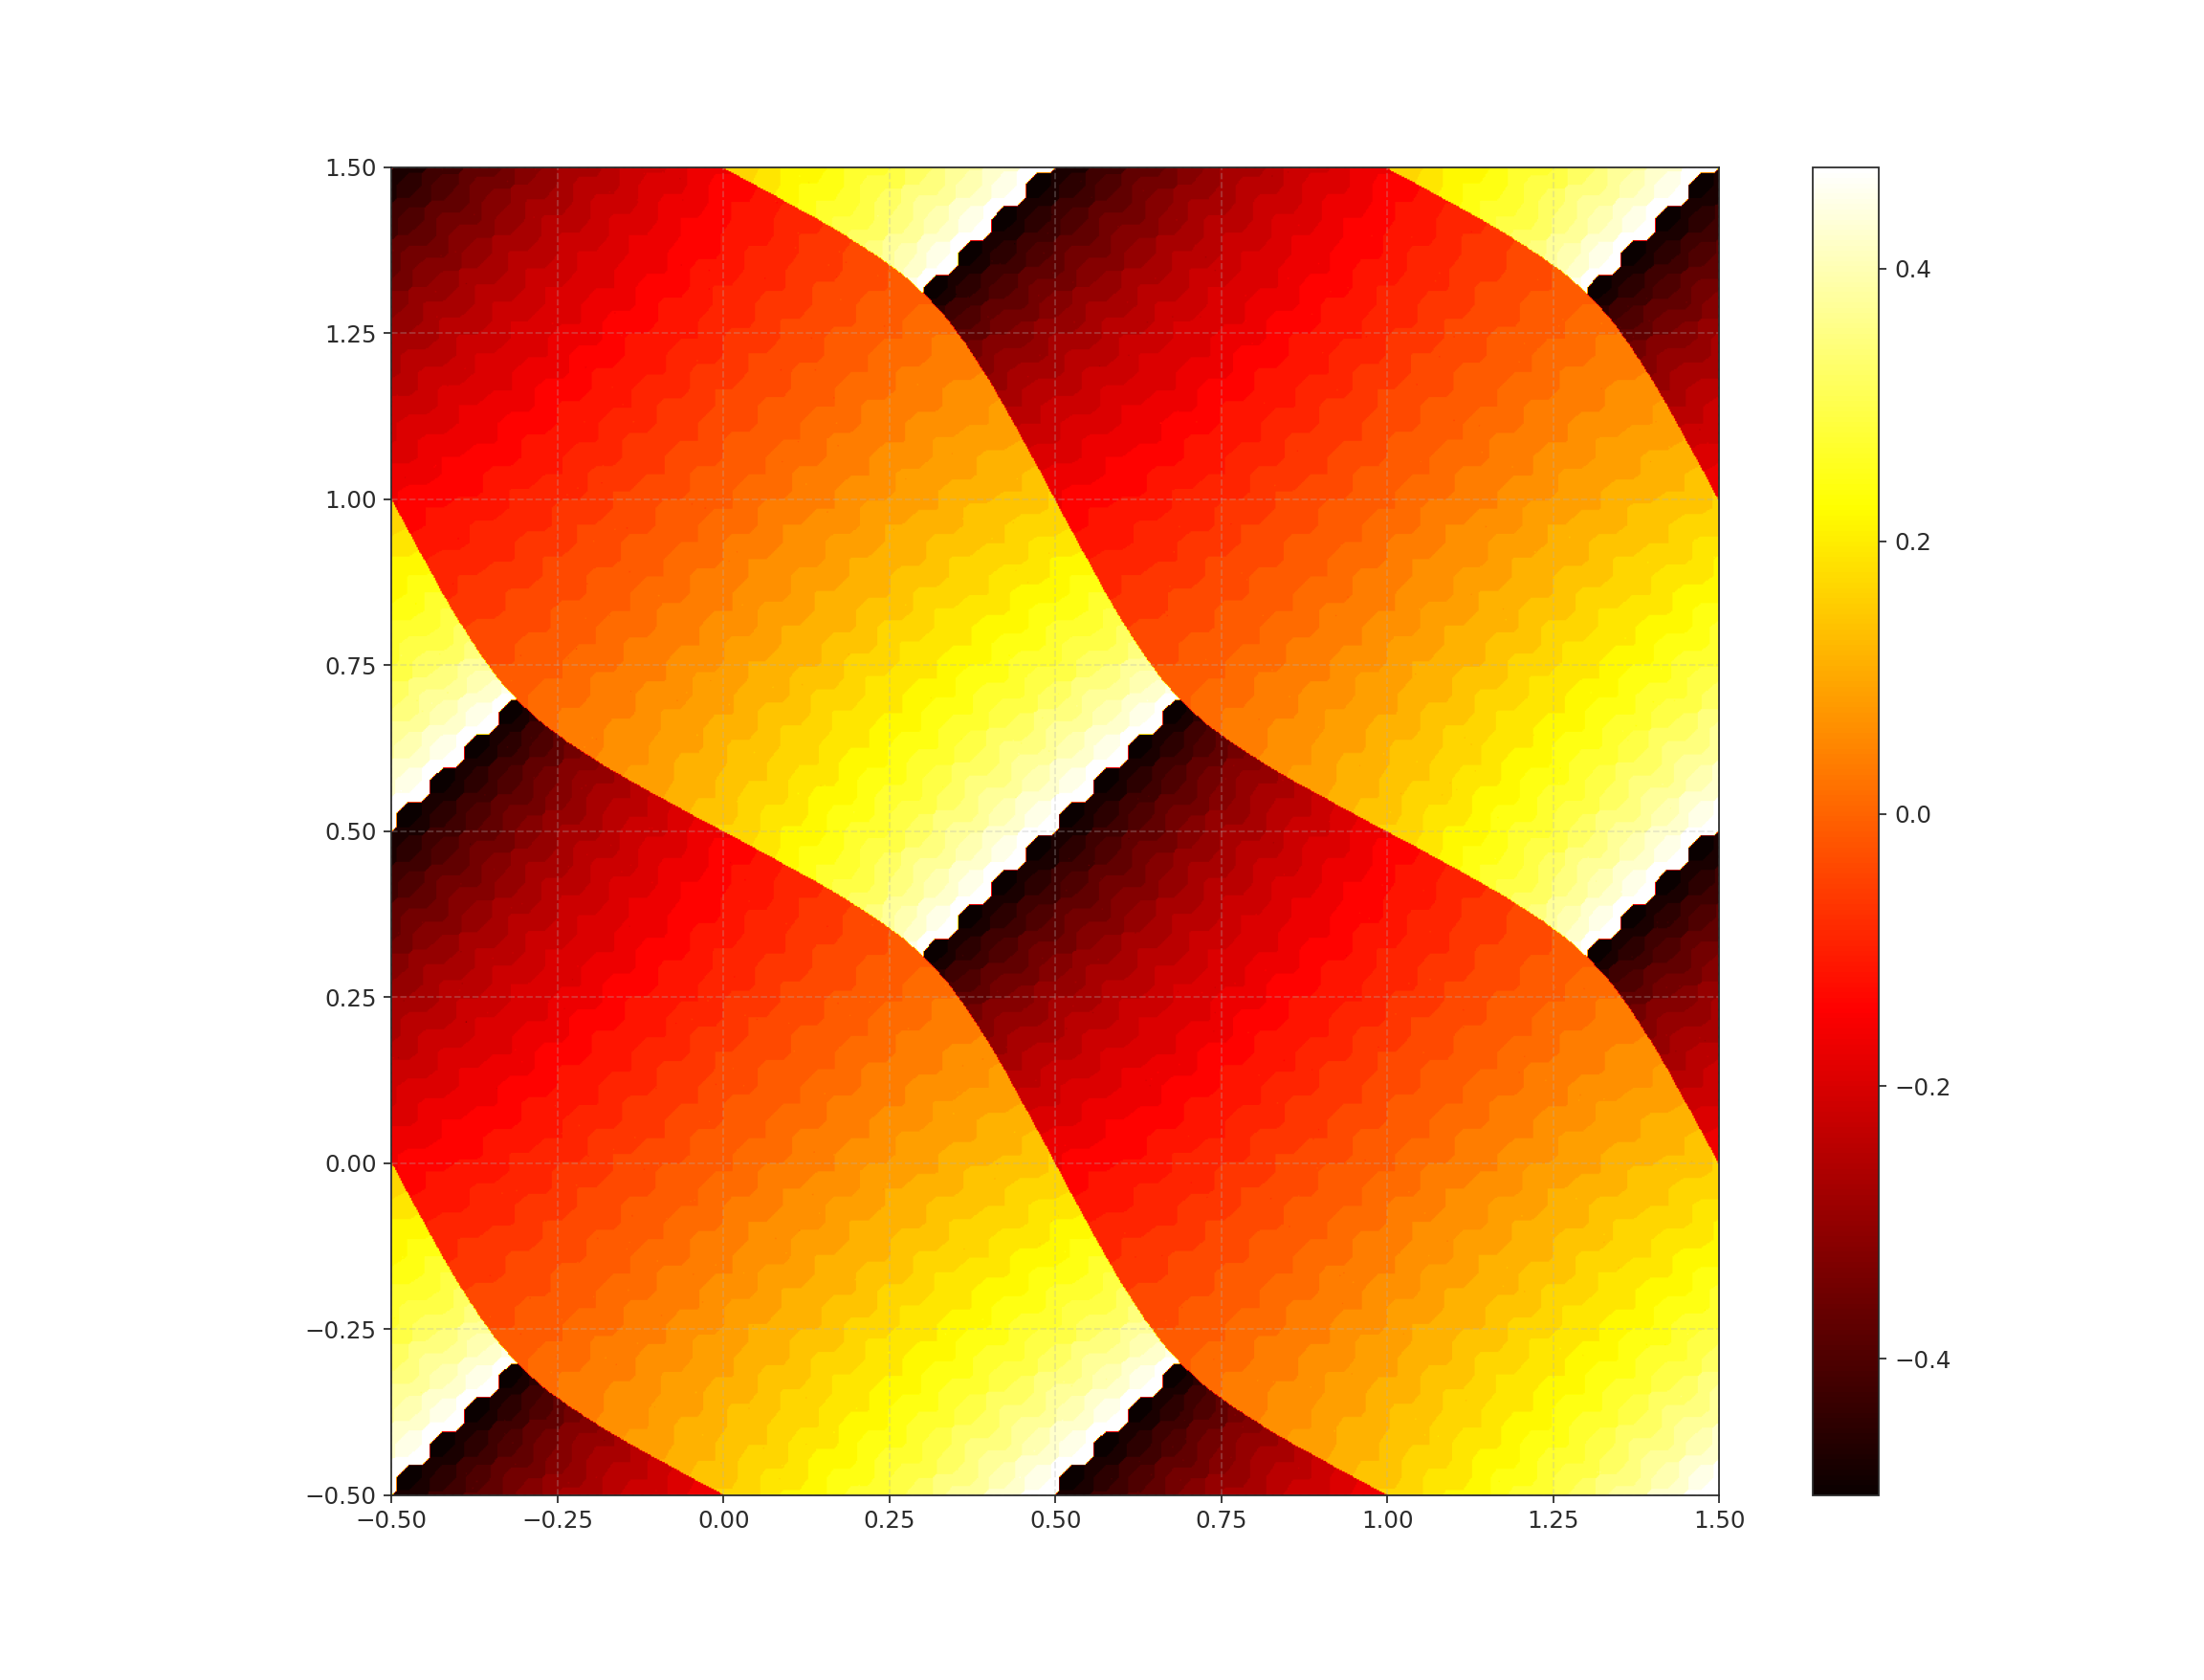

In [41]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6))

im = ax.imshow(
    #result["potential"],
    result["phi02"],
    #result["phi03"],
    #quadrants["potential"][0][0],
    extent = [LOWER, UPPER, LOWER, UPPER],
    origin= 'lower',
    #cmap='summer',
    cmap='hot',
    #interpolation='spline36',
    #vmin=0, vmax=2.5
)
cbar = fig.colorbar(im)
#cbar.set_ticks([0, 0.5, 1, 1.5, 2, 2.5])

<IPython.core.display.Javascript object>


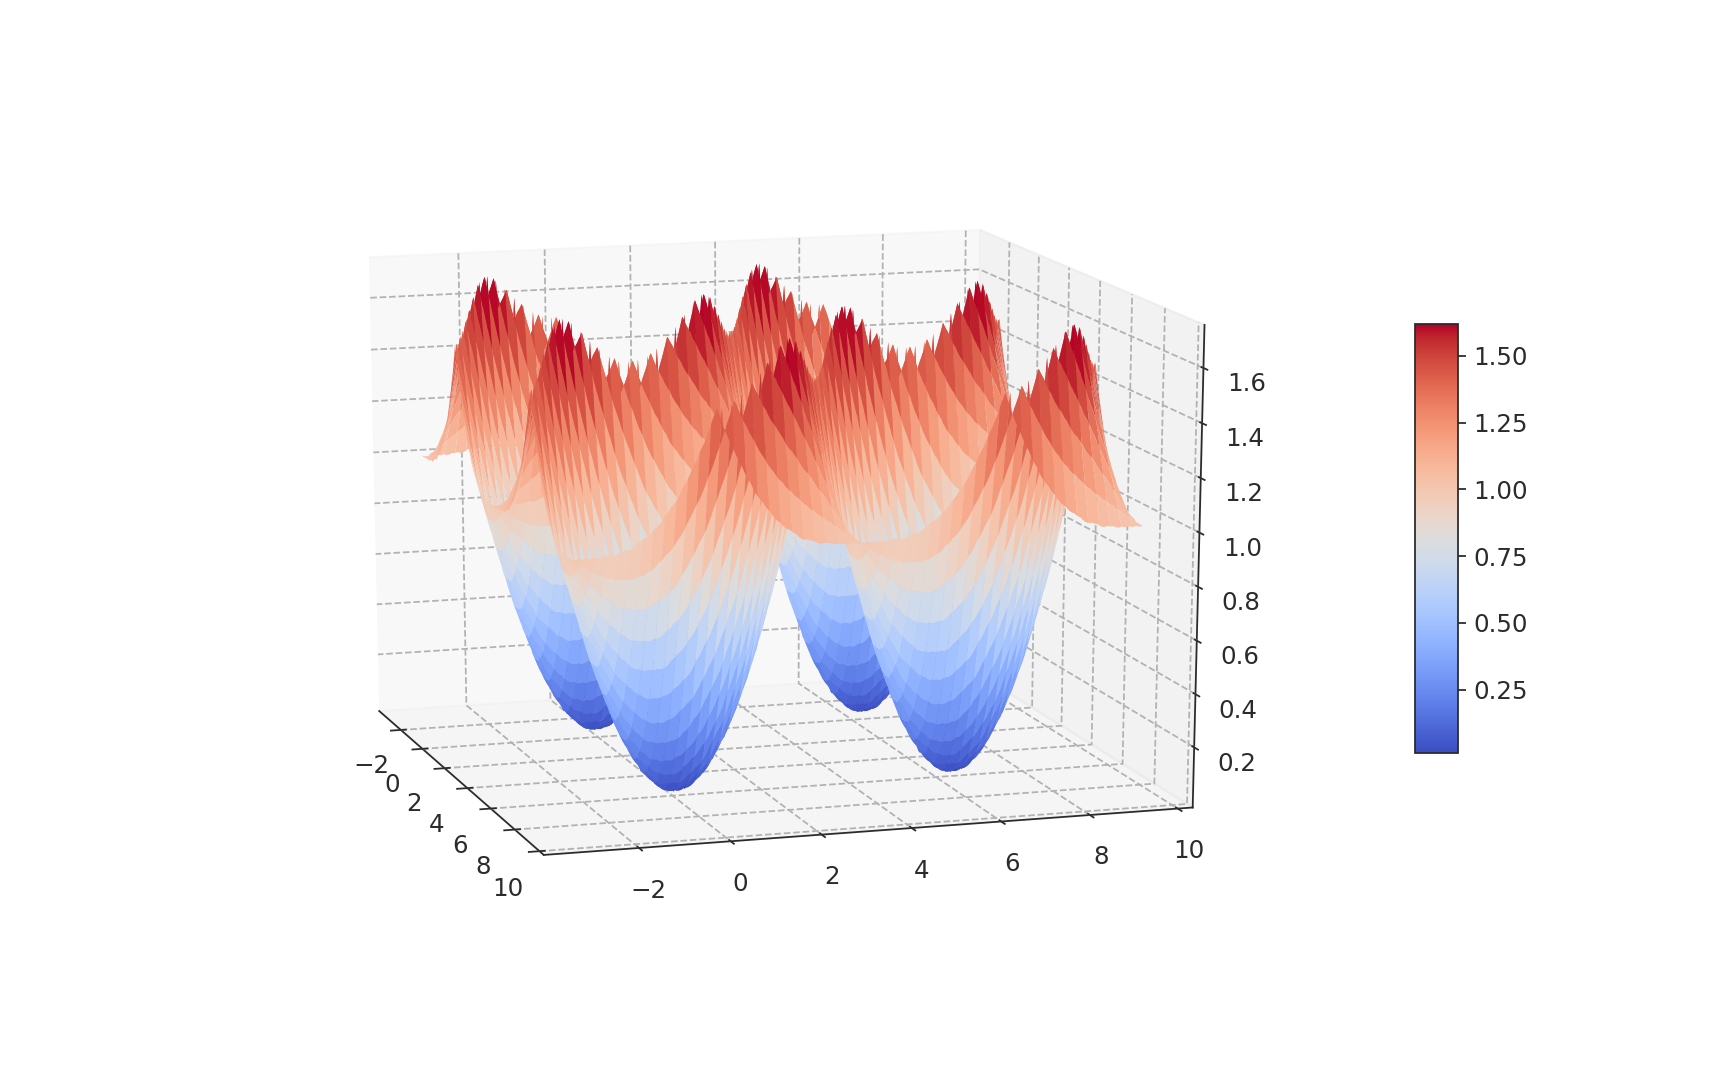

In [42]:
%matplotlib notebook

fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')

grid_x, grid_y = np.meshgrid(lr_array, lr_array)
surf = ax.plot_surface(grid_x, grid_y, 
                       result["potential"], 
                       #quadrants["potential"][0][0],
                       cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=10)